In [88]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
# ----------------------------
# 1. Load & Inspect Data
# ----------------------------
# Reference: Ho et al. (2014) - HarvardX-MITx dataset paper
df = pd.read_csv("/Users/rekha/Documents/Thesis - 2024/Dataset/dataverse_files/HXPC13_DI_v3_11-13-2019.csv")

# Filter to key variables from documentation
cols = ['userid_DI', 'course_id', 'registered', 'viewed', 'explored', 'certified', 
        'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI',
        'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 
        'nforum_posts']

df = df[cols]  # Filter to relevant columns
print(df.head(10))

        userid_DI                   course_id  registered  viewed  explored  \
0  MHxPC130442623  HarvardX/CB22x/2013_Spring           1       0         0   
1  MHxPC130275857  HarvardX/CB22x/2013_Spring           1       0         0   
2  MHxPC130539455  HarvardX/CB22x/2013_Spring           1       1         0   
3  MHxPC130088379  HarvardX/CB22x/2013_Spring           1       1         0   
4  MHxPC130024894  HarvardX/CB22x/2013_Spring           1       1         0   
5  MHxPC130340959  HarvardX/CB22x/2013_Spring           1       1         0   
6  MHxPC130148402  HarvardX/CB22x/2013_Spring           1       0         0   
7  MHxPC130435030  HarvardX/CB22x/2013_Spring           1       1         0   
8  MHxPC130542822  HarvardX/CB22x/2013_Spring           1       1         0   
9  MHxPC130069044  HarvardX/CB22x/2013_Spring           1       0         0   

   certified final_cc_cname_DI LoE_DI  YoB gender grade start_time_DI  \
0          0     United States    NaN  NaN    NaN     0  

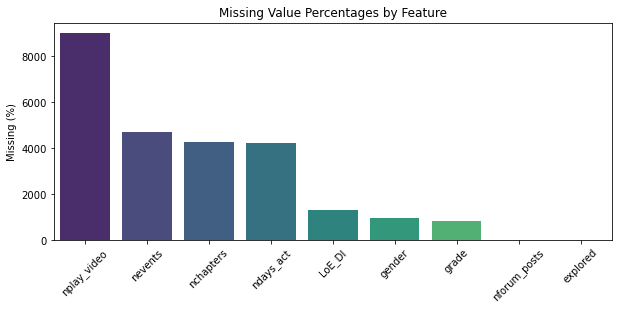

In [90]:
# ----------------------------
# 2. Handle Missing Data
# ----------------------------
# Reference: García-Laencina et al. (2010) - Missing data strategies in education

# Convert to numeric and handle empty strings
for col in ['nplay_video', 'nchapters', 'nforum_posts', 'nevents', 'ndays_act', 'grade']:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
    
# Calculate missing percentages
#print("Missing values before handling:")
#print(df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters', 'explored']].isnull().sum())

missing = (df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters', 'explored']].isnull().sum().sort_values(ascending=False) / len(df)) * 100

# Visualize missingness (Reference: Wickham, 2016 - Visualization for analysis)
plt.figure(figsize=(10,4))
sns.barplot(x=missing.index, y=missing*100, palette="viridis")
plt.title("Missing Value Percentages by Feature")
plt.ylabel("Missing (%)")
plt.xticks(rotation=45)
plt.show()

# Median imputation for numerical features (Reference: Han et al., 2011)
num_cols = ['nevents', 'ndays_act', 'grade', 'nforum_posts']
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Mode imputation for categoricals (Reference: Al-Shabandar et al., 2018)
cat_cols = ['LoE_DI', 'gender']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])



In [91]:
# ----------------------------
# 3. Structural Missingness Handling
# ----------------------------
# Reference: Khalil & Ebner (2017) - MOOC engagement patterns

# Flag non-engaged learners before imputation
df['no_video_interaction'] = df['nplay_video'].isnull().astype(int)
df['no_activity'] = (df['nevents'].isnull() | df['ndays_act'].isnull() | df['nchapters'].isnull()).astype(int)

# Zero-imputation for structural non-engagement (Reference: Ho et al., 2014)
high_missing_cols = ['nplay_video', 'nevents', 'nchapters', 'ndays_act']
df[high_missing_cols] = df[high_missing_cols].fillna(0)  # Structural non-engagement

# Handle grade (critical outcome variable)
df['grade'] = df['grade'].fillna(0)  # 0 = no credit earned


Missing values after handling:


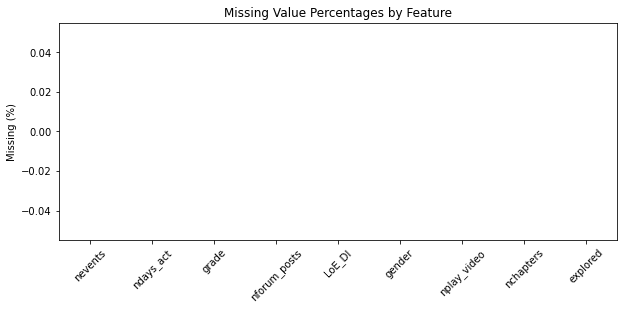


Non-engagement flag distribution:
Users with no video interaction: 90.16%
Users with no activity: 42.71%


In [92]:
# ----------------------------
# 4. Post-Imputation Validation
# ----------------------------
# Reference: Gardner & Brooks (2018) - MOOC data validation
print("\nMissing values after handling:")
#print(df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters']].isnull().sum())

missing = (df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters', 'explored']].isnull().sum().sort_values(ascending=False) / len(df)) * 100

plt.figure(figsize=(10,4))
sns.barplot(x=missing.index, y=missing*100, palette="viridis")
plt.title("Missing Value Percentages by Feature")
plt.ylabel("Missing (%)")
plt.xticks(rotation=45)
plt.show()

print("\nNon-engagement flag distribution:")
print(f"Users with no video interaction: {df['no_video_interaction'].mean()*100:.2f}%")
print(f"Users with no activity: {df['no_activity'].mean()*100:.2f}%")

In [93]:
# ----------------------------
# 5. Feature Engineering
# ----------------------------
# Reference: Boroujeni & Dillenbourg (2019) - Temporal engagement metrics

# Laplace smoothing to handle zero-inflation (Reference: Chen & Goodman, 1999)
df['engagement_intensity'] = (df['nevents'] + 1) / (df['ndays_act'] + 2)

# Knowledge check ratio (chapters completed vs videos watched)
df['quiz_to_video_ratio'] = (df['nchapters'] + 1) / (df['nplay_video'] + 2)

# Temporal features (Reference: Peach et al., 2019)
df['start_time_DI'] = pd.to_datetime(df['start_time_DI'])
df['last_event_DI'] = pd.to_datetime(df['last_event_DI'])
df['learning_duration'] = (df['last_event_DI'] - df['start_time_DI']).dt.days

In [94]:
# ----------------------------
# 6. Normalization
# ----------------------------
# Reference: Han et al. (2011) - Data preprocessing for clustering

scaler = StandardScaler()
numeric_features = ['nevents', 'ndays_act', 'nplay_video', 'nforum_posts',
                   'nchapters', 'engagement_intensity', 
                   'quiz_to_video_ratio']

df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nSample processed data:")
print(df[numeric_features + ['grade', 'no_activity']].head(3))


Sample processed data:
    nevents  ndays_act  nplay_video  nforum_posts  nchapters  \
0 -0.164504   0.749226    -0.085858     -0.076049  -0.503593   
1 -0.164504   1.730947    -0.085858     -0.076049  -0.503593   
2 -0.128348   0.328488    -0.085858     -0.076049   0.252547   

   engagement_intensity  quiz_to_video_ratio  grade  no_activity  
0             -0.376349            -0.416205    0.0            1  
1             -0.403414            -0.416205    0.0            1  
2             -0.217347             0.377125    0.0            0  



Missing values after handling:
userid_DI                    0
course_id                    0
registered                   0
viewed                       0
explored                     0
certified                    0
final_cc_cname_DI            0
LoE_DI                       0
YoB                      38504
gender                       0
grade                        0
start_time_DI                0
last_event_DI           152231
nevents                      0
ndays_act                    0
nplay_video                  0
nchapters                    0
nforum_posts                 0
engagement_intensity         0
quiz_to_video_ratio          0
dtype: int64

Sample engineered features:
   engagement_intensity  quiz_to_video_ratio  learning_duration
0             -0.376349            -0.416205              333.0
1             -0.403414            -0.416205              282.0
2             -0.217347             0.377125              133.0
3              0.157974             0.377125      

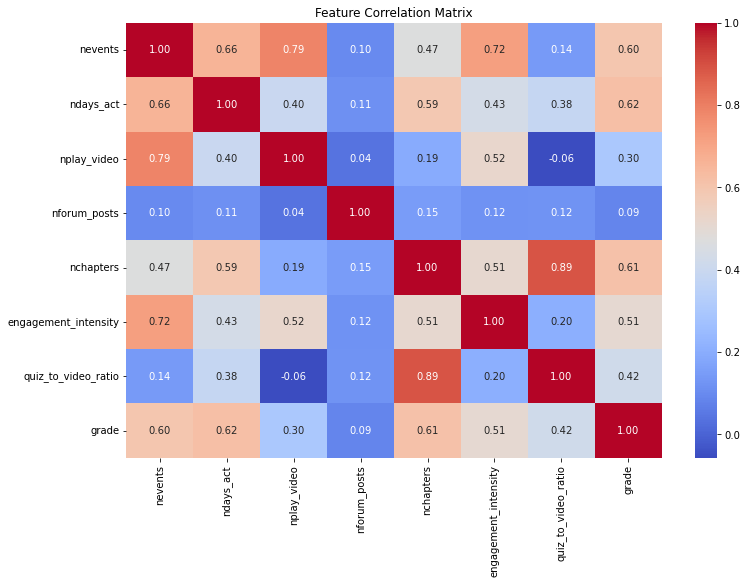

In [95]:
# ----------------------------
# Output Validation
# ----------------------------
# Correlation analysis (Reference: Romero & Ventura, 2010)

print("\nMissing values after handling:")
print(df[cols + ['engagement_intensity', 'quiz_to_video_ratio']].isnull().sum())

print("\nSample engineered features:")
print(df[['engagement_intensity', 'quiz_to_video_ratio', 'learning_duration']].head())

print("\nCorrelation matrix:")
#print(df[features_to_scale + ['grade']].corr())

corr_matrix = df[numeric_features + ['grade']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()